In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as lflns
sns.set_style('whitegrid')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [2]:
%run -i ../examples/concordance_index.ipynb

In [3]:
# Load training data and impute categorical variables.

hct_df = pd.read_csv("../data/train_set.csv")

# Replace text value that corresponding so missing data with NaN
hct_df = hct_df.replace(to_replace=["Missing Disease Status", "Missing disease status"], value=np.nan)

# drop columns that aren't appropriate for prediction
hct_df = hct_df.drop(columns=['year_hct'])

In [4]:
cat_cols = list(hct_df.select_dtypes(include='O').columns)

encoder = ColumnTransformer(
    [
        ('one_hot', 
         OneHotEncoder(drop='first', 
                       min_frequency=0.001, 
                       handle_unknown='ignore',
                       ), 
        cat_cols
        ),
    ],
    sparse_threshold=0,
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )

df_enc = pd.DataFrame(encoder.fit_transform(hct_df), 
                      columns=encoder.get_feature_names_out()).drop("ID", axis=1)

In [5]:
def create_pipeline(to_scale = ['donor_age', 'age_at_hct', 'karnofsky_score']):
    pipeline = Pipeline(
        [
            (
                "scale",
                ColumnTransformer(
                    [
                        ('scale', StandardScaler(), to_scale)
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )
            ),
            (
                "impute",
                KNNImputer()
            ),
        ]
    )

    return pipeline

In [6]:
feat_names = df_enc.columns[:-2]
target_names = ['efs', 'efs_time']

n_splits=5
kfold = KFold(n_splits=n_splits, shuffle=True)
scores = np.zeros(n_splits)

from lifelines import CoxPHFitter

for num, (train_idx, test_idx) in enumerate(kfold.split(df_enc)):
    
    train = df_enc.iloc[train_idx]
    test = df_enc.iloc[test_idx]
    
    pipeline = create_pipeline()

    X_train_proc = pd.DataFrame(pipeline.fit_transform(train[feat_names]), 
                                columns=pipeline.get_feature_names_out()).set_index(train_idx)
    y_train_proc = train[target_names]
    train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

    X_test_proc = pd.DataFrame(pipeline.transform(test[feat_names]),
                              columns=pipeline.get_feature_names_out()).set_index(test_idx)
    y_test_proc = test[target_names]
    test_proc = pd.concat([X_test_proc, y_test_proc], axis=1)

    cph = CoxPHFitter()
    cph.fit(train_proc, duration_col='efs_time', event_col='efs')
    
    preds = cph.predict_partial_hazard(test_proc)

    solution = hct_df.iloc[test_idx]
    prediction = pd.DataFrame({"ID":hct_df.iloc[test_idx]["ID"], "prediction":preds})
    scores[num] = score(solution.copy(deep=True), prediction.copy(deep=True), "ID")

print(scores)

[0.65461258 0.65278639 0.64410161 0.65829284 0.65122656]


In [7]:
np.mean(scores)

np.float64(0.6522039966541151)

In [8]:
pipeline = create_pipeline()

X_train_proc = pd.DataFrame(pipeline.fit_transform(df_enc[feat_names]), columns=pipeline.get_feature_names_out())
y_train_proc = df_enc[target_names]
train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

cph = CoxPHFitter()

cph.fit(train_proc, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>

In [9]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12428
   partial log-likelihood = -118077.72
         time fit was run = 2025-04-01 03:30:30 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
donor_age                                                    0.04      1.04      0.01            0.02            0.06                1.02                1.06
age_at_hct                                                   0.03      1.03      0.01            0.01            0.06                1.01                1.06
karnofsky_score                                             -0.06      0.94      0.01           -0.08           -0.04                0.92                0.96
dri_score_High - TED AML case <missing cytogenetics         -0.36      0.70      0.05           -0.44           -0.27                0.64                0.77
dri_score_Intermediate                                      -0.44      0.64      0.03           -0.49           -0.39                0.61                0.68
dri_score_Intermediate - TED AML case <missing cytogenetics -0.34      0.71      0.07           -0.48           -0.20                0.62                0.82
dri_score_Low                                               -0.34      0.71      0.04           -0.42           -0.26                0.66                0.77
dri_score_N/A - disease not classifiable                    -0.49      0.62      0.11           -0.71           -0.26                0.49                0.77
dri_score_N/A - non-malignant indication                    -0.38      0.69      0.04           -0.46           -0.29                0.63                0.75
dri_score_N/A - pediatric                                   -0.38      0.69      0.03           -0.44           -0.31                0.64                0.74
dri_score_TBD cytogenetics                                  -0.28      0.75      0.05           -0.37           -0.19                0.69                0.83
dri_score_Very high                                         -0.23      0.79      0.13           -0.49            0.02                0.61                1.03
dri_score_nan                                               -0.62      0.54      0.13           -0.89           -0.36                0.41                0.70
psych_disturb_Not done                                       0.01      1.01      0.13           -0.25            0.26                0.78                1.30
psych_disturb_Yes                                            0.03      1.03      0.03           -0.02            0.09                0.98                1.09
psych_disturb_nan                                            0.09      1.10      0.06           -0.02            0.20                0.98                1.22
cyto_score_Intermediate                                      0.14      1.15      0.04            0.07            0.21                1.07                1.23
cyto_score_Normal                                            0.24      1.27      0.07            0.11            0.36                1.12                1.44
cyto_score_Not tested                                        0.04      1.04      0.20           -0.36            0.44                0.70                1.55
cyto_score_Other                                             0.25      1.28      0.07            0.10            0.39                1.11                1.48
cyto_score_Poor                                              0.22      1.25      0.03            0.15            0.29                1.16                1

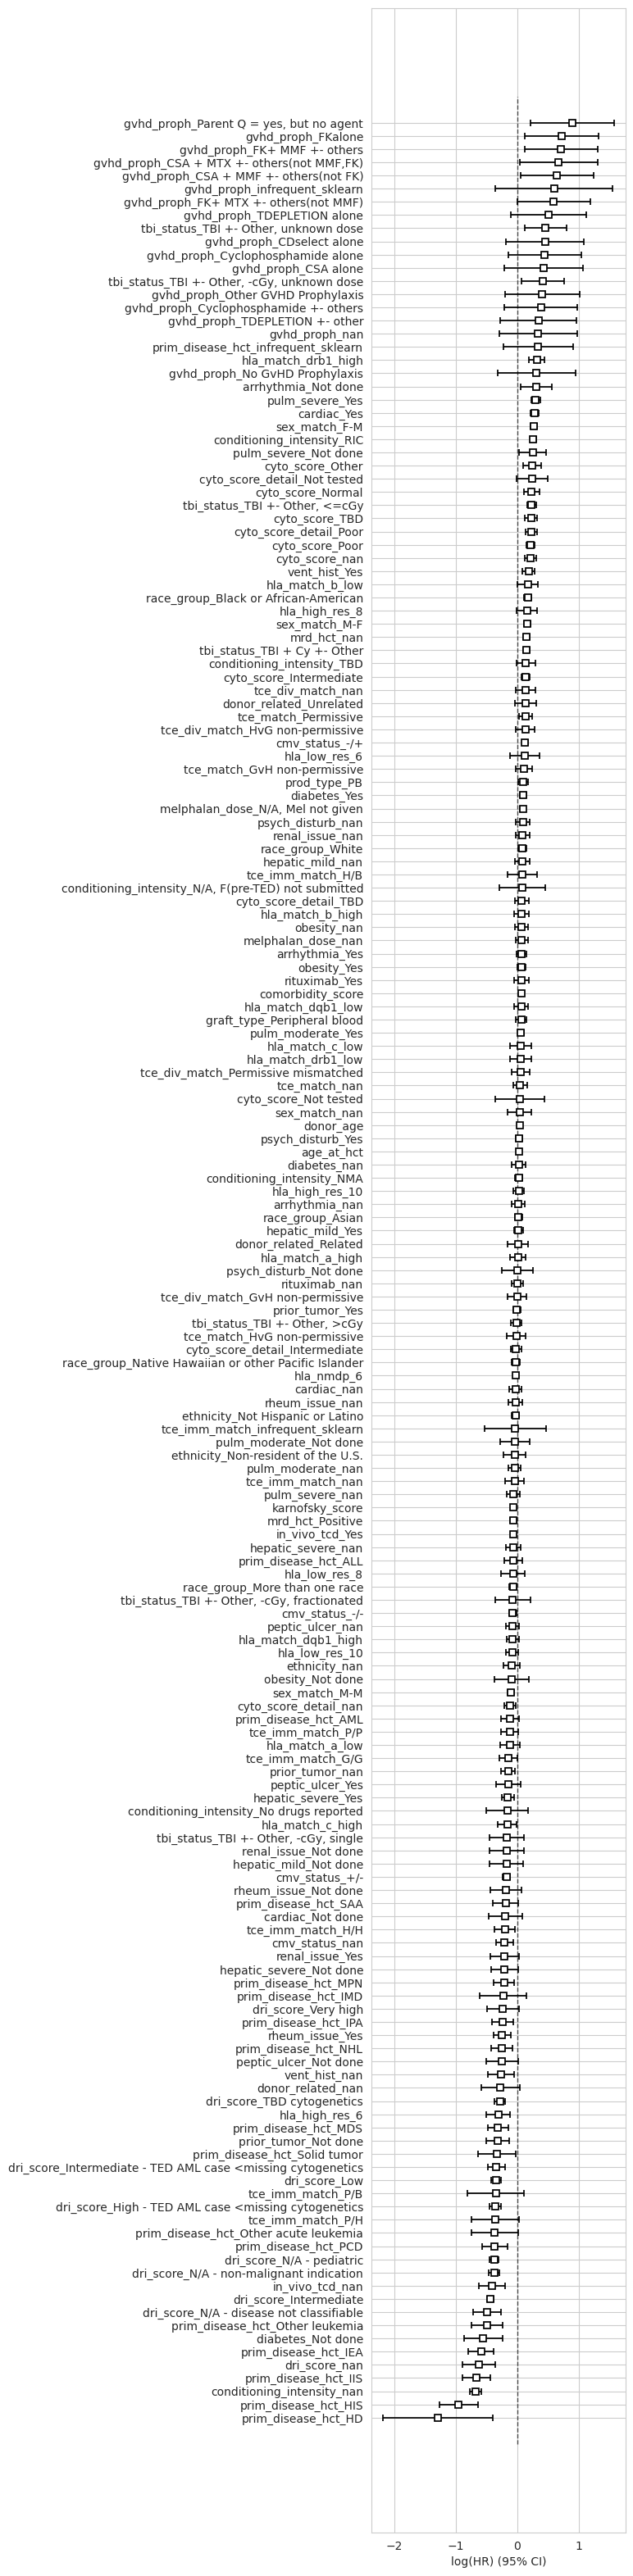

In [10]:
plt.figure(figsize=(4, 40))
cph.plot()
plt.show()

In [11]:
coefficient_info = pd.concat([cph.params_, cph.confidence_intervals_], axis=1).reset_index()
coefficient_info['abs_coef'] = abs(coefficient_info['coef'])
coefficient_info['zero not in conf int'] = coefficient_info['95% lower-bound'] * coefficient_info['95% upper-bound'] > 0

In [12]:
significant_coefs = coefficient_info.loc[coefficient_info['zero not in conf int']]
print("There are {} statistically significant coefficients".format(significant_coefs.shape[0]))

There are 78 statistically significant coefficients


In [13]:
key_columns = significant_coefs.covariate.to_list() + ['efs', 'efs_time']

In [14]:
scale_key = [col for col in ['donor_age', 'age_at_hct', 'karnofsky_score'] if col in key_columns]

In [16]:
df_key = df_enc[key_columns]
scale_key = [col for col in ['donor_age', 'age_at_hct', 'karnofsky_score'] if col in key_columns]
feat_names_key = key_columns[:-2]

for num, (train_idx, test_idx) in enumerate(kfold.split(df_key)):
    
    train = df_key.iloc[train_idx]
    test = df_key.iloc[test_idx]
    
    pipeline = create_pipeline(scale_key)


    X_train_proc = pd.DataFrame(pipeline.fit_transform(train[feat_names_key]), 
                                columns=pipeline.get_feature_names_out()).set_index(train_idx)

    y_train_proc = train[target_names]
    train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

    X_test_proc = pd.DataFrame(pipeline.transform(test[feat_names_key]), 
                               columns=pipeline.get_feature_names_out()).set_index(test_idx)
    y_test_proc = test[target_names]
    test_proc = pd.concat([X_test_proc, y_test_proc], axis=1)

    cph = CoxPHFitter()
    cph.fit(train_proc, duration_col='efs_time', event_col='efs')

    preds = cph.predict_partial_hazard(test_proc)

    solution = hct_df.iloc[test_idx]
    prediction = pd.DataFrame({"ID":hct_df.iloc[test_idx]["ID"], "prediction":preds})
    scores[num] = score(solution.copy(deep=True), prediction.copy(deep=True), "ID")

print(scores)

[0.65487498 0.64845109 0.64879395 0.65580206 0.64672212]


In [17]:
np.mean(scores)

np.float64(0.6509288398058812)

In [18]:
pipeline = create_pipeline(scale_key)

X_train_key = pd.DataFrame(pipeline.fit_transform(df_key[feat_names_key]), columns=pipeline.get_feature_names_out())
y_train_key = df_key[target_names]
train_key = pd.concat([X_train_proc, y_train_proc], axis=1)

In [19]:
# Fox a cox regression model out of the box
from lifelines import CoxPHFitter
cph2 = CoxPHFitter()
cph2.fit(train_key, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 18432 total observations, 8516 right-censored observations>

In [20]:
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 18432 total observations, 8516 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 18432
number of events observed = 9916
   partial log-likelihood = -92109.12
         time fit was run = 2025-04-01 03:36:18 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
donor_age                                                    0.02      1.02      0.01            0.00            0.04                1.00                1.05
age_at_hct                                                   0.03      1.03      0.01           -0.00            0.05                1.00                1.05
karnofsky_score                                             -0.06      0.95      0.01           -0.08           -0.03                0.93                0.97
dri_score_High - TED AML case <missing cytogenetics         -0.32      0.72      0.05           -0.42           -0.22                0.66                0.80
dri_score_Intermediate                                      -0.42      0.66      0.03           -0.48           -0.36                0.62                0.70
dri_score_Intermediate - TED AML case <missing cytogenetics -0.35      0.70      0.08           -0.51           -0.19                0.60                0.83
dri_score_Low                                               -0.28      0.75      0.04           -0.37           -0.20                0.69                0.82
dri_score_N/A - disease not classifiable                    -0.54      0.58      0.13           -0.79           -0.29                0.45                0.75
dri_score_N/A - non-malignant indication                    -0.35      0.71      0.05           -0.44           -0.25                0.64                0.78
dri_score_N/A - pediatric                                   -0.34      0.71      0.04           -0.42           -0.26                0.66                0.77
dri_score_TBD cytogenetics                                  -0.26      0.77      0.05           -0.36           -0.16                0.70                0.85
dri_score_nan                                               -0.54      0.58      0.15           -0.83           -0.25                0.44                0.78
cyto_score_Intermediate                                      0.13      1.14      0.04            0.06            0.21                1.06                1.23
cyto_score_Normal                                            0.24      1.28      0.07            0.10            0.38                1.11                1.47
cyto_score_Other                                             0.21      1.24      0.08            0.05            0.37                1.05                1.45
cyto_score_Poor                                              0.21      1.24      0.04            0.14            0.29                1.15                1.33
cyto_score_TBD                                               0.21      1.23      0.06            0.09            0.32                1.10                1.38
cyto_score_nan                                               0.17      1.18      0.05            0.07            0.26                1.07                1.30
diabetes_Not done                                           -0.54      0.58      0.17           -0.88           -0.20                0.41                0.82
diabetes_Yes                                                 0.10      1.10      0.03            0.04            0.15                1.04                1.17
tbi_status_TBI + Cy +- Other                                 0.16      1.17      0.03            0.10            0.21                1.11                1.24

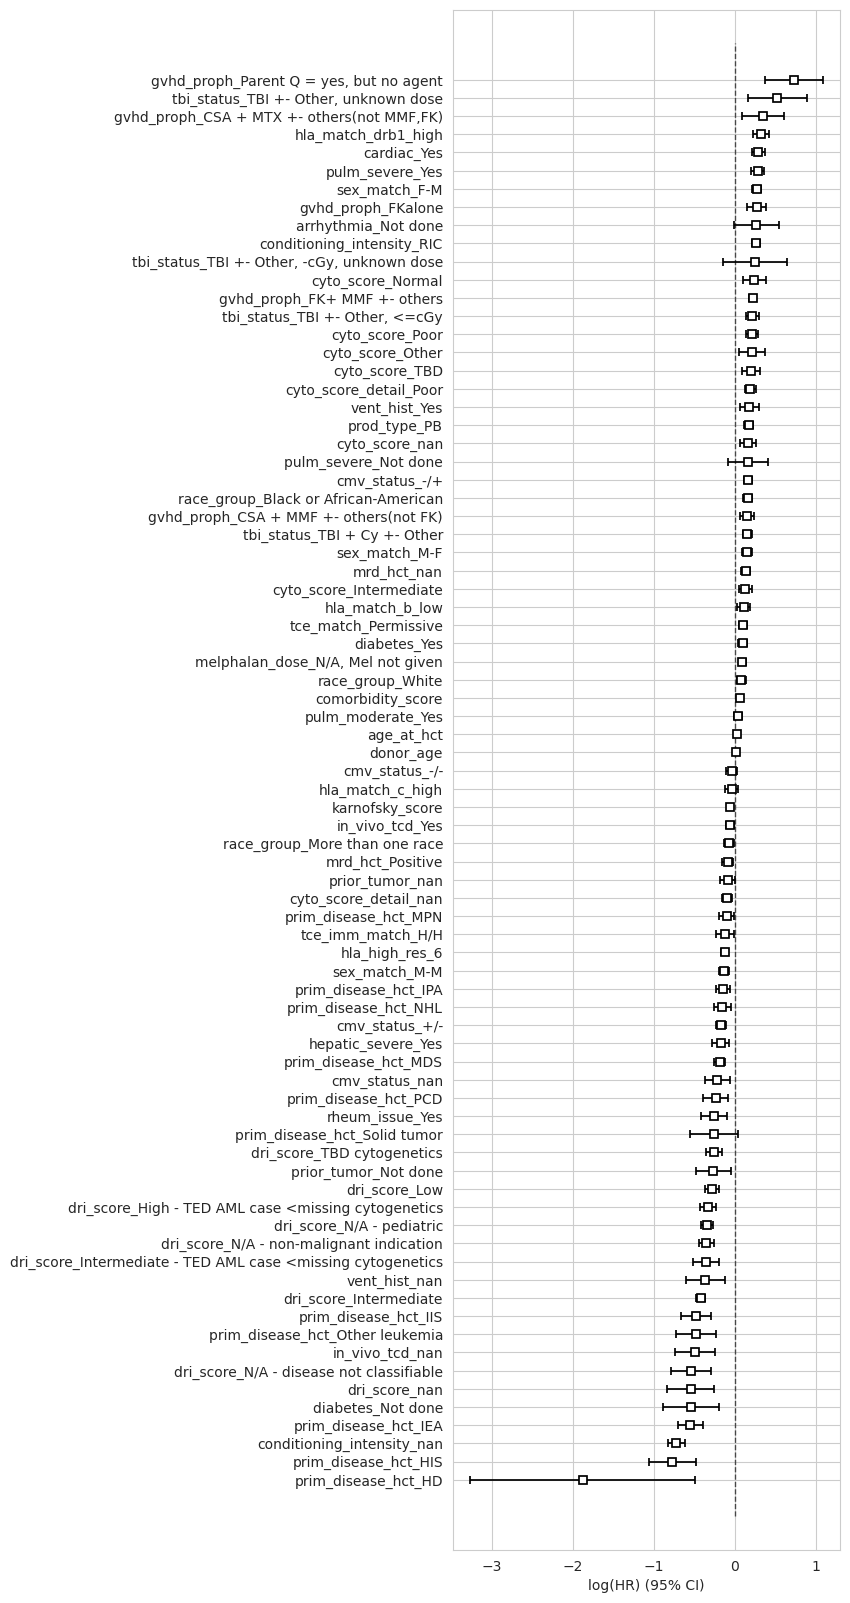

In [21]:
plt.figure(figsize=(5, 20))
cph2.plot()
plt.show()